In [109]:
import sys
# print(sys.path)
sys.path.append('c:\\users\\24556\\appdata\\local\\programs\\python\\python37\\lib\\site-packages')

# coding=gbk

# coding=gbk

import numpy as np
import random
import matplotlib.pyplot as plt
import argparse
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score

# from MIA.membership_inference import ShadowModel, AttackerModel, Membership_Inference
from aijack.attack import ShadowModel, AttackerModel, Membership_Inference
from aijack.utils import NumpyDataset
from itertools import chain
import csv
import os

In [110]:
parser=argparse.ArgumentParser()
parser.add_argument('--train_num', type=int, default=5000, help="train num for train set")
parser.add_argument('--test_num', type=int, default=1000, help="test num for test set")
parser.add_argument('--seed',type=int,default=2)
parser.add_argument('--epoch', type=int, default=10, help="train epoch")
parser.add_argument('--num_label', type=int, default=10, help="dataset num label")
parser.add_argument('--RPMAX', type=int, default=10, help="repeat experiment")
parser.add_argument('--noise_level',type=float,default=0,help='feature noise')
#args = parser.parse_args(args=[])
# args = parser.parse_args()
args = parser.parse_args([])

In [111]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean

    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean

    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

In [112]:
def generate_train_data(X_train, y_train, shadow_train_percent, target_train_percent, train_num, seed):
    np.random.seed(seed)
    label_index_shadow_train = random.sample(list(np.argwhere(y_train == 3)),
                                             k=int((np.around(shadow_train_percent, 3)[3]) * train_num))
    for i in chain(range(3), range(4, 10)):
        np.random.seed(seed)
        label_idx_temp_train = random.sample(list(np.argwhere(y_train == i)),
                                             k=int((np.around(shadow_train_percent, 3)[i]) * train_num))
        label_index_shadow_train = np.concatenate([label_index_shadow_train, np.array(label_idx_temp_train)], axis=0)

    label_three_index_train = np.argwhere(y_train == 3)
    temp_index = np.setdiff1d(label_three_index_train, label_index_shadow_train)
    np.random.seed(seed)
    label_index_all_target = random.sample(list(temp_index), k=int((np.around(target_train_percent, 3)[3]) * train_num))
    for i in chain(range(3), range(4, 10)):
        temp_index_target = np.setdiff1d(np.argwhere(y_train == i), label_index_shadow_train)
        np.random.seed(seed)
        label_idx_temp_target = random.sample(list(temp_index_target),
                                              k=int((np.around(target_train_percent, 3)[i]) * train_num))
        label_index_all_target = np.concatenate([label_index_all_target, np.array(label_idx_temp_target)], axis=0)

    np.random.shuffle(label_index_shadow_train)
    np.random.shuffle(label_index_all_target)

    target_train_idx = label_index_all_target
    shadow_train_idx = label_index_shadow_train

    X_target_train = X_train[target_train_idx]
    X_shadow_train = np.squeeze(X_train[shadow_train_idx], 1)

    y_target_train = y_train[target_train_idx]
    y_shadow_train = np.squeeze(y_train[shadow_train_idx], 1)

    return X_target_train, y_target_train, X_shadow_train, y_shadow_train


def generate_test_data(X_test, y_test, shadow_test_percent, target_test_percent, test_num, seed):
    np.random.seed(seed)
    label_index_shadow_test = random.sample(list(np.argwhere(y_test == 3)),
                                            k=int((np.around(shadow_test_percent, 3)[3]) * test_num))
    for i in chain(range(3), range(4, 10)):
        np.random.seed(seed)
        label_idx_temp_test = random.sample(list(np.argwhere(y_test == i)),
                                            k=int((np.around(shadow_test_percent, 3)[i]) * test_num))
        label_index_shadow_test = np.concatenate([label_index_shadow_test, np.array(label_idx_temp_test)], axis=0)

    label_three_index_test = np.argwhere(y_test == 3)
    temp_index = np.setdiff1d(label_three_index_test, label_index_shadow_test)
    np.random.seed(args.seed)
    label_index_all_target = random.sample(list(temp_index),
                                           k=int(int((np.around(target_test_percent, 3)[3]) * test_num)))
    for i in chain(range(3), range(4, 10)):
        temp_index_target = np.setdiff1d(np.argwhere(y_test == i), label_index_shadow_test)
        np.random.seed(args.seed)
        label_idx_temp_target = random.sample(list(temp_index_target),
                                              k=int(int((np.around(target_test_percent, 3)[i]) * test_num)))
        label_index_all_target = np.concatenate([label_index_all_target, np.array(label_idx_temp_target)], axis=0)
    np.random.shuffle(label_index_shadow_test)
    np.random.shuffle(label_index_all_target)

    target_test_idx = label_index_all_target
    shadow_test_idx = label_index_shadow_test
    X_target_test = X_test[target_test_idx]
    X_shadow_test = np.squeeze(X_test[shadow_test_idx], 1)
    y_target_test = y_test[target_test_idx]
    y_shadow_test = np.squeeze(y_test[shadow_test_idx], 1)

    return X_target_test, y_target_test, X_shadow_test, y_shadow_test

In [113]:
trainset = torchvision.datasets.CIFAR10(root="./data", train=True, download=False)
testset = torchvision.datasets.CIFAR10(root="./data", train=False, download=False)
X_train = trainset.data
y_train = np.array(trainset.targets)

X_test = testset.data
y_test = np.array(testset.targets)

In [114]:
# 分割shadow,target数据
np.random.seed(args.seed)
# shadow_percent = np.random.dirichlet(np.repeat(args.beta, 10))
shadow_percent = np.array([0.1 for i in range(10)])
target_percent = np.array([0.1 for i in range(10)])
X_target_train, y_target_train, X_shadow_train, y_shadow_train = generate_train_data(X_train, y_train,
                                                                                     shadow_percent, target_percent,
                                                                                     args.train_num, args.seed)
X_target_test, y_target_test, X_shadow_test, y_shadow_test = generate_test_data(X_test, y_test, shadow_percent,
                                                                                target_percent, args.test_num,
                                                                                args.seed)

In [121]:
X_target_train.shape

(5000, 32, 32, 3)

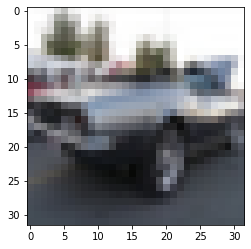

In [124]:
import matplotlib.pyplot as plt # plt 用于显示图片
plt.imshow(X_target_train[0])

In [133]:
transform_add_noise = transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),AddGaussianNoise(0., noise_level)]
    )
transform = transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
    )
transform_test = transforms.Compose(
        [transforms.ToTensor(),AddGaussianNoise(0., noise_level)]
    )
victimset = NumpyDataset(X_target_train, y_target_train, transform=transform_test)
# victimloader = torch.utils.data.DataLoader(
#         victimset, batch_size=4, shuffle=True, num_workers=2
#     )
victimloader = torch.utils.data.DataLoader(
        victimset, batch_size=4, shuffle=True, num_workers=0
    )
valset = NumpyDataset(X_target_test, y_target_test, transform=transform)
# valloader = torch.utils.data.DataLoader(
#         valset, batch_size=4, shuffle=True, num_workers=2
#     )
valloader = torch.utils.data.DataLoader(
        valset, batch_size=4, shuffle=True, num_workers=0
    )

In [134]:
train_dataset_array = next(iter(victimloader))[0].numpy()

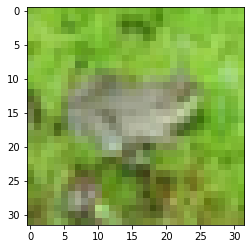

In [135]:
plt.imshow(train_dataset_array[0].transpose(1,2,0))

In [71]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(
            in_channels=3, out_channels=64, kernel_size=3, padding=1, stride=1
        )
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.conv4 = nn.Conv2d(256, 512, 3, padding=1)
        self.bn4 = nn.BatchNorm2d(512)
        self.L1 = nn.Linear(2048, 10)

    def forward(self, x):
        # 3ch > 64ch, shape 32 x 32 > 16 x 16
        x = self.conv1(x)  # [64,32,32]
        x = self.bn1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2, 2)  # [64,16,16]

        # 64ch > 128ch, shape 16 x 16 > 8 x 8
        x = self.conv2(x)  # [128,16,16]
        x = self.bn2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2, 2)  # [128,8,8]

        # 128ch > 256ch, shape 8 x 8 > 4 x 4
        x = self.conv3(x)  # [256,8,8]
        x = self.bn3(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2, 2)  # [256,4,4]

        # 256ch > 512ch, shape 4 x 4 > 2 x 2
        x = self.conv4(x)  # [512,4,4]
        x = self.bn4(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2, 2)  # [512,2,2]

        x = x.view(-1, 2048)  # [256,2048]
        x = self.L1(x)
        # x = F.softmax(x, dim=0)
        return x


In [72]:
 device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)



# # 加载数据集
# trainset = torchvision.datasets.CIFAR10(root="./data", train=True, download=False)
# testset = torchvision.datasets.CIFAR10(root="./data", train=False, download=False)
# X_train = trainset.data
# y_train = np.array(trainset.targets)

# X_test = testset.data
# y_test = np.array(testset.targets)

# # 分割shadow,target数据
# np.random.seed(args.seed)
# # shadow_percent = np.random.dirichlet(np.repeat(args.beta, 10))
# shadow_percent=[0.086,  0.214,  0.006, 0.001,  0.026,  0.026,  0.136,  0.086,
#     0.205,  0.214]

# target_percent = np.array([0.1 for i in range(10)])
# X_target_train, y_target_train, X_shadow_train, y_shadow_train = generate_train_data(X_train, y_train,
#                                                                                      shadow_percent, target_percent,
#                                                                                      args.train_num, args.seed)
# X_target_test, y_target_test, X_shadow_test, y_shadow_test = generate_test_data(X_test, y_test, shadow_percent,
#                                                                                 target_percent, args.test_num,
#                                                                                 args.seed)
# # 可视化各个label数据分布
# plt.xticks(range(0, 10, 1))
# value_shadow_train, count_shadow_train = np.unique(y_shadow_train, return_counts=True)
# plt.bar(
#     list(value_shadow_train),
#     list(count_shadow_train),

# )
# plt.title("data number of each label in shadow set ")
# plt.xlabel("label")
# plt.ylabel("number")
# plt.savefig("./img/shadow set label number-{}.png".format(args.beta))

# # ToTensor：数据标准化并转化成batch_size的iterator
# transform = transforms.Compose(
#     [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
# )

# victimset = NumpyDataset(X_target_train, y_target_train, transform=transform)
# victimloader = torch.utils.data.DataLoader(
#     victimset, batch_size=4, shuffle=True, num_workers=2
# )

# valset = NumpyDataset(X_target_test, y_target_test, transform=transform)
# valloader = torch.utils.data.DataLoader(
#     valset, batch_size=4, shuffle=True, num_workers=2
# )
# # target model train
# victim_net = Net()
# victim_net = victim_net.to(device)
#
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(victim_net.parameters(), lr=0.005, momentum=0.9)

# # train shadow models
# shadow_models = [Net().to(device), Net().to(device)]
# shadow_transform = transform
# shadow_data_size = 25000  # 不用管
# num_label = args.num_label
# attack_models = [SVC(probability=True) for i in range(num_label)]

y_shadow_train = np.array(y_shadow_train).astype(np.int64)
y_shadow_test = np.array(y_shadow_test).astype(np.int64)


def run_exp():  # 实验次数
    # target model train
    victim_net = Net()
    victim_net = victim_net.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(victim_net.parameters(), lr=0.005, momentum=0.9)
    for epoch in range(args.epoch):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(victimloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            labels = labels.to(torch.int64)
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = victim_net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 2000 == 1999:  # print every 2000 mini-batches
                print("[%d, %5d] loss: %.3f" % (epoch + 1, i + 1, running_loss / 2000))
                running_loss = 0.0

        test_preds = []
        test_label = []
        with torch.no_grad():
            for data in valloader:
                inputs, labels = data
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = victim_net(inputs)
                test_preds.append(outputs)
                test_label.append(labels)
            test_preds = torch.cat(test_preds)
            test_label = torch.cat(test_label)

        print(
            accuracy_score(
                torch.argmax(test_preds, axis=1).cpu().detach().numpy(),
                test_label.cpu().detach().numpy(),))
            

    print("Finished Training")
    # 输出train_set，test_set的posterior,并计算target overfitting
    in_preds = []
    in_label = []
    with torch.no_grad():
        for data in victimloader:
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = victim_net(inputs)
            in_preds.append(outputs)
            in_label.append(labels)
        in_preds = torch.cat(in_preds)
        in_label = torch.cat(in_label)
#     print(
#         "train_accuracy: ",
#         accuracy_score(
#             torch.argmax(in_preds, axis=1).cpu().detach().numpy(),
#             in_label.cpu().detach().numpy(),)
        

    out_preds = []
    out_label = []
    with torch.no_grad():
        for data in valloader:
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = victim_net(inputs)
            out_preds.append(outputs)
            out_label.append(labels)
        out_preds = torch.cat(out_preds)
        out_label = torch.cat(out_label)
#     print(
#         "test_accuracy: ",
#         accuracy_score(
#             torch.argmax(out_preds, axis=1).cpu().detach().numpy(),
#             out_label.cpu().detach().numpy(),
#         ),
#     )

#     target_overfitting = accuracy_score(
#         torch.argmax(in_preds, axis=1).cpu().detach().numpy(),
#         in_label.cpu().detach().numpy(),
#     ) - accuracy_score(
#         torch.argmax(out_preds, axis=1).cpu().detach().numpy(),
#         out_label.cpu().detach().numpy(),)

    
    # np.save("./result/target_overfitting_{}.npy".format(args.beta), target_overfitting)
    #         item = np.array([target_overfitting])
    # fieldnames = ['overall']
    #         with open('target_overfitting.csv', mode='a', newline='', encoding='utf-8-sig') as f:
    #             writer = csv.writer(f)
    #             # 判断表格内容是否为空，如果为空就添加表头
    #             # if not os.path.getsize('target_overfitting.csv'):
    #             #   writer.writeheader()  # 写入表头
    #             writer.writerows([item])

    # 可视化每个label的overfitting level

    in_pred_numpy = torch.argmax(in_preds, axis=1).cpu().detach().numpy()
    in_label_numpy = in_label.cpu().detach().numpy()

    out_pred_numpy = torch.argmax(out_preds, axis=1).cpu().detach().numpy()
    out_label_numpy = out_label.cpu().detach().numpy()

    target_model_overfitting_per_label = {}
    print("train_accuracy - test_accuracy")
    for label in np.unique(in_label_numpy):
        in_label_idx = np.where(in_label_numpy == label)
        out_label_idx = np.where(out_label_numpy == label)

#         train_score = accuracy_score(
#             in_pred_numpy[in_label_idx], in_label_numpy[in_label_idx]
#         )
#         test_score = accuracy_score(
#             out_pred_numpy[out_label_idx], out_label_numpy[out_label_idx]
#         )
        print(out_pred_numpy[out_label_idx].shape, out_label_numpy[out_label_idx].shape)

        print(f"label {label}: ", train_score - test_score)
        print(train_score)
        print(test_score)
        target_model_overfitting_per_label[label] = train_score - test_score
    # np.save("./result/target_model_overfitting_per_label-{}.npy".format(args.beta), target_model_overfitting_per_label)
    #         item = target_model_overfitting_per_label
    #         fieldnames = target_model_overfitting_per_label.keys()
    #         with open('target_model_overfitting_per_label.csv', mode='a', newline='', encoding='utf-8-sig') as f:
    #             writer = csv.DictWriter(f, fieldnames=fieldnames)
    #             # 判断表格内容是否为空，如果为空就添加表头
    #             if not os.path.getsize('target_model_overfitting_per_label.csv'):
    #                 writer.writeheader()  # 写入表头
    #             writer.writerows([item])

    # my_x_ticks = np.arange(0, 10, 1)
    # plt.xticks(my_x_ticks)
    # plt.bar(list(target_model_accuracy_per_label.keys()), list(target_model_accuracy_per_label.values()))
    # plt.title("target model overfitting per label")
    # plt.xlabel("label")
    # plt.ylabel("overfitting level")
    #
    # plt.savefig("./img/target model overfitting per label-{}.png".format(args.beta))

    # # train shadow models
    # shadow_models = [Net().to(device), Net().to(device)]
    # shadow_transform = transform
    # shadow_data_size = 25000  # 不用管
    # num_label = args.num_label
    # attack_models = [SVC(probability=True) for i in range(num_label)]
    #
    # y_shadow_train = np.array(y_shadow_train).astype(np.int64)
    # y_shadow_test = np.array(y_shadow_test).astype(np.int64)
    # train shadow models
    shadow_models = [Net().to(device), Net().to(device)]
    shadow_transform = transform
    shadow_data_size = 25000  # 不用管
    num_label = args.num_label
    attack_models = [SVC(probability=True) for i in range(num_label)]

    mi = Membership_Inference(victim_net, shadow_models, attack_models, shadow_data_size, shadow_transform)

    shadow_model_overfitting_per_label, shadow_overfitting = mi.train_shadow(X_shadow_train, y_shadow_train,
                                                                             X_shadow_test, y_shadow_test,
                                                                             num_itr=args.epoch)
    mi.train_attacker()
    # np.save("./result/shadow_overfitting_{}.npy".format(args.beta),shadow_model_overfitting)

    #         item = np.array([shadow_overfitting])
    #         # fieldnames = ['overall']
    #         with open('shadow_overfitting.csv', mode='a', newline='', encoding='utf-8-sig') as f:
    #             writer = csv.writer(f)
    #             # 判断表格内容是否为空，如果为空就添加表头
    #             # if not os.path.getsize('shadow_overfitting.csv'):
    #             #   writer.writeheader()  # 写入表头
    #             writer.writerows([item])

    # np.save("./result/shadow_model_accuracy_per_label-{}.npy".format(args.beta), shadow_model_overfitting_per_label)

    #         item = shadow_model_overfitting_per_label
    #         fieldnames = shadow_model_overfitting_per_label.keys()
    #         with open('shadow_model_overfitting_per_label.csv', mode='a', newline='', encoding='utf-8-sig') as f:
    #             writer = csv.DictWriter(f, fieldnames=fieldnames)
    #             # 判断表格内容是否为空，如果为空就添加表头
    #             if not os.path.getsize('shadow_model_overfitting_per_label.csv'):
    #                 writer.writeheader()  # 写入表头
    #             writer.writerows([item])

    # plt.xticks(range(0, 10, 1))
    # plt.bar(list(shadow_model_accuracy_per_label.keys()), list(shadow_model_accuracy_per_label.values()))
    # plt.title("shadow model overfitting per label")
    # plt.xlabel("label")
    # plt.ylabel("overfitting level")
    # plt.savefig("./img/shadow model overfitting per label-{}.png".format(args.beta))
    # MIA auc
    attacked_pred_in_prob = mi.predict_proba(in_preds, in_label)  # 是指cifar 10 class的label
    attacked_pred_out_prob = mi.predict_proba(out_preds, out_label)
    score = roc_auc_score(np.concatenate([np.ones_like(attacked_pred_in_prob), np.zeros_like(attacked_pred_out_prob)]),np.concatenate([attacked_pred_in_prob, attacked_pred_out_prob]),)
    print("overall auc is ", score)
    # np.save("./result/attack_auc-{}".format(args.beta), score)

    #         item = np.array([score])
    #         # fieldnames = ['overall']
    #         with open('attack_auc.csv', mode='a', newline='', encoding='utf-8-sig') as f:
    #             writer = csv.writer(f)
    #             # 判断表格内容是否为空，如果为空就添加表头
    #             # if not os.path.getsize('attack_auc.csv'):
    #             #   writer.writeheader()  # 写入表头
    #             writer.writerows([item])

    in_label_numpy = in_label.cpu().numpy()
    out_label_numpy = out_label.cpu().numpy()

    attack_model_auc_per_label = {}

    for label in np.unique(in_label_numpy):
        in_label_idx = np.where(in_label_numpy == label)
        out_label_idx = np.where(out_label_numpy == label)
        score = roc_auc_score(
            np.concatenate(
                [
                    np.ones_like(attacked_pred_in_prob[in_label_idx]),
                    np.zeros_like(attacked_pred_out_prob[out_label_idx]),
                ]
            ),
            np.concatenate([attacked_pred_in_prob[in_label_idx], attacked_pred_out_prob[out_label_idx]]),)
        print(f"label {label}: ", score)
        attack_model_auc_per_label[label] = score
    # np.save("./result/attack_model_auc_per_label-{}.npy".format(args.beta), attack_model_auc_per_label)
    #         item = attack_model_auc_per_label
    #         fieldnames = attack_model_auc_per_label.keys()
    #         with open('attack_model_auc_per_label.csv', mode='a', newline='', encoding='utf-8-sig') as f:
    #             writer = csv.DictWriter(f, fieldnames=fieldnames)
    #             # 判断表格内容是否为空，如果为空就添加表头
    #             if not os.path.getsize('attack_model_auc_per_label.csv'):
    #                 writer.writeheader()  # 写入表头
    #             writer.writerows([item])
    return target_overfitting, target_model_overfitting_per_label, shadow_overfitting, shadow_model_overfitting_per_label, score, attack_model_auc_per_label


Results_value = []
Results_dict_tar = []
Results_dict_sha = []
Results_dict_auc = []
for RP in range(args.RPMAX):
    target_overfitting, target_model_overfitting_per_label, shadow_overfitting, shadow_model_overfitting_per_label, score, attack_model_auc_per_label = run_exp()
    Results_value.append([target_overfitting, shadow_overfitting, score])
    Results_dict_tar.append(target_model_overfitting_per_label.values())
    Results_dict_sha.append(shadow_model_overfitting_per_label.values())
    Results_dict_auc.append(attack_model_auc_per_label.values())
target_overfitting_mean, shadow_overfitting_mean, score_mean = np.mean(Results_value, axis=0)
target_overfitting_std, shadow_overfitting_std, score_std = np.std(Results_value, axis=0)
target_model_overfitting_per_label_mean = np.mean([list(i) for i in list(Results_dict_tar)], axis=0)
shadow_model_overfitting_per_label_mean = np.mean([list(i) for i in list(Results_dict_sha)], axis=0)
attack_model_auc_per_label_mean = np.mean([list(i) for i in list(Results_dict_auc)], axis=0)

item = np.array([target_overfitting_mean,target_overfitting_std,shadow_overfitting_mean,shadow_overfitting_std, score_mean,score_std])
# fieldnames = ['overall']
with open('./result/Results_value_{}.csv'.format(args.beta), mode='a', newline='', encoding='utf-8-sig') as f:
    writer = csv.writer(f)
    # 判断表格内容是否为空，如果为空就添加表头
    # if not os.path.getsize('target_overfitting.csv'):
    #   writer.writeheader()  # 写入表头
    writer.writerows([item])

item_tar = target_model_overfitting_per_label_mean
item_sha = shadow_model_overfitting_per_label_mean
item_auc = attack_model_auc_per_label_mean
# fieldnames = ['overall']
with open('./result/Results_dict_{}.csv'.format(args.beta), mode='a', newline='', encoding='utf-8-sig') as f:
    writer = csv.writer(f)
    # 判断表格内容是否为空，如果为空就添加表头
    # if not os.path.getsize('target_overfitting.csv'):
    #   writer.writeheader()  # 写入表头
    writer.writerows([item_tar])
    writer.writerows([item_sha])
    writer.writerows([item_auc])

cpu


KeyboardInterrupt: 